In [3]:
import os
from torch import nn
from torch.nn.functional import one_hot
import torch 
import numpy as np
from matplotlib import pyplot as plt
import math
import torch.nn.functional as F
import pickle 


In [4]:

#change current directory up to parent, only run 1 time!
os.chdir("..")

In [5]:
test_id = [0,1,2,3,5,6,10,11,12,19,20,21,22,24,26,28,29,32,33,35,36,39,40,43,45,46,47,50,51,52]

In [4]:
#loads data from clean_data 
#path need to be set to the clean_data folder
def load_data(test=False,Print=False,path=f'{os.path.abspath(os.curdir)}/data/carseg_data/clean_data',nr_img=1499):
    train_data_input=[]
    train_data_target=[]
    path1 = f'{os.path.abspath(os.curdir)}/data/carseg_data/carseg_raw_data/train/photo'
    
    if test:
        for i in range (len(test_id)):
            n = test_id[i]
            n1 = f'{n}_a'
            test1=np.load(f'{path}/{n1}.npy')
            inputs=torch.from_numpy(test1[:3])
            target=torch.from_numpy(test1[3])
            #target= torch.unsqueeze(target,0)
            train_data_input.append(inputs)
            train_data_target.append(target)
            
            
            
    else:

        for n in range(nr_img):
            n1=n
            
            if (n1 not in test_id):
                n2 = f'{n}_a'
                
                if os.path.exists(f'{path1}/{n2}.jpg'):
                    test2=np.load(f'{path}/{n2}.npy')
                    inputs2=torch.from_numpy(test2[:3])
                    target2=torch.from_numpy(test2[3])
                    #target= torch.unsqueeze(target,0)
                    train_data_input.append(inputs2)
                    train_data_target.append(target2)
            
            #if test:
            #    if (n1 in test_id):
            #        #n1=f'{n}_a'
            
            if os.path.exists(f'{path1}/{n1}.jpg'):
                test1=np.load(f'{path}/{n1}.npy')
                inputs=torch.from_numpy(test1[:3])
                target=torch.from_numpy(test1[3])
                #target= torch.unsqueeze(target,0)
                train_data_input.append(inputs)
                train_data_target.append(target)
                
            
    return [train_data_input,train_data_target]

In [5]:

#Load test and train data
test_data=load_data(test=True)
train_data=load_data()

#split op into x and y
test_x, test_y = test_data[0], test_data[1]
train_x, train_y = train_data[0], train_data[1]



In [6]:

#the form of data is:
#data[0] is a list with all rgb img's as tensor
#data[1] is a list with all targets as tensor  
def Get_stats(data):
    print(f'Number of img {len(data[0])}')
    print(f'target sahpe {data[1][0].shape}')
    print(f'input shape {data[0][0].shape}')
    
    
#print some info about data structure
print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)


test_data:
Number of img 30
target sahpe torch.Size([256, 256])
input shape torch.Size([3, 256, 256])
train_data:
Number of img 139
target sahpe torch.Size([256, 256])
input shape torch.Size([3, 256, 256])


In [7]:
#for i in range (len(train_x)):
#    a = torch.permute(train_x[i], (1,2,0))
#    plt.imshow(a)
#    plt.show()




'''
from torchvision import transforms
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
'''

'\nfrom torchvision import transforms\ndata_transform = transforms.Compose([\n        transforms.RandomSizedCrop(224),\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n        transforms.Normalize(mean=[0.485, 0.456, 0.406],\n                             std=[0.229, 0.224, 0.225])\n    ])\n'

In [8]:

#create data structure
from torch.utils import data
class batches(data.Dataset):
    def __init__(self, x_set, y_set,transform=None):
        self.transform=transform
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return math.ceil(len(self.x))
    
    def __getitem__(self, idx):
        batch_x = self.x[idx]
        batch_y = self.y[idx]
        if self.transform:
            batch_x = self.transform(batch_x)
        return batch_x.type(self.inputs_dtype),batch_y.type(self.inputs_dtype)



In [9]:

# # one hot encoder
# 

def one_hot_target(target):
    l=[0]*len(target)
    for targets in range(len(target)):
        l[targets] = one_hot(target[targets].to(torch.int64), num_classes=9)
        l[targets] = torch.permute(l[targets], (2,0,1))
    return l

In [10]:

test_y_one=one_hot_target(test_y)
train_y_one=one_hot_target(train_y)

In [11]:

print('test_data:')
Get_stats([test_x, test_y_one])
print('train_data:')
Get_stats([train_x, train_y_one])

test_data:
Number of img 30
target sahpe torch.Size([9, 256, 256])
input shape torch.Size([3, 256, 256])
train_data:
Number of img 139
target sahpe torch.Size([9, 256, 256])
input shape torch.Size([3, 256, 256])


In [12]:

from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F




# based on:
# https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py


In [13]:

class DiceLoss(nn.Module):
    r"""Criterion that computes Sørensen-Dice Coefficient loss.

    According to [1], we compute the Sørensen-Dice Coefficient as follows:

    .. math::

        \text{Dice}(x, class) = \frac{2 |X| \cap |Y|}{|X| + |Y|}

    where:
       - :math:`X` expects to be the scores of each class.
       - :math:`Y` expects to be the one-hot tensor with the class labels.

    the loss, is finally computed as:

    .. math::

        \text{loss}(x, class) = 1 - \text{Dice}(x, class)

    [1] https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

    Shape:
        - Input: :math:`(N, C, H, W)` where C = number of classes.
        - Target: :math:`(N, H, W)` where each value is
          :math:`0 ≤ targets[i] ≤ C−1`.

    Examples:
        >>> N = 5  # num_classes
        >>> loss = tgm.losses.DiceLoss()
        >>> input = torch.randn(1, N, 3, 5, requires_grad=True)
        >>> target = torch.empty(1, 3, 5, dtype=torch.long).random_(N)
        >>> output = loss(input, target)
        >>> output.backward()
    """

    def __init__(self) -> None:
        super(DiceLoss, self).__init__()
        self.eps: float = 1e-6

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))
        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # create the labels one hot tensor
        #target_one_hot = one_hot(target, num_classes=input.shape[1],
        #                         device=input.device, dtype=input.dtype)

        # compute the actual dice score
        dims = (1, 2, 3)
        intersection = torch.sum(input_soft * target, dims)
        cardinality = torch.sum(input_soft + target, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        return torch.mean(1. - dice_score)



In [14]:

def dice_loss(
        input: torch.Tensor,
        target: torch.Tensor) -> torch.Tensor:
    r"""Function that computes Sørensen-Dice Coefficient loss.

    See :class:`~torchgeometry.losses.DiceLoss` for details.
    """
    return DiceLoss()(input, target)

In [15]:


val_x=train_x[:20]
ttrain_x=train_x[20:]

val_y_one=train_y_one[:20]
ttrain_y_one=train_y_one[20:]



In [16]:

#creats all the layers we need


@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer


def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)


def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)


def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()


def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y

# creat the model
class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 3,
                 out_channels: int = 8,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)
        
        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)
        
        # initialize the weights
        self.initialize_parameters()
        

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)
        x = torch.softmax(x,dim=1)
        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0] and 'training' not in attr_key}
        d = {self.__class__.__name__: attributes}
        return f'{d}'

In [17]:

#creat a model with 4 bloks
model = UNet(in_channels=3,
             out_channels=9,
             n_blocks=4,
             start_filters=9,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

x = torch.randn(size=(4,3, 256, 256), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

Out: torch.Size([4, 9, 256, 256])


In [18]:
from torchsummary import summary
summary = summary(model, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 9, 256, 256]             252
              ReLU-2          [-1, 9, 256, 256]               0
       BatchNorm2d-3          [-1, 9, 256, 256]              18
            Conv2d-4          [-1, 9, 256, 256]             738
              ReLU-5          [-1, 9, 256, 256]               0
       BatchNorm2d-6          [-1, 9, 256, 256]              18
         MaxPool2d-7          [-1, 9, 128, 128]               0
         DownBlock-8  [[-1, 9, 128, 128], [-1, 9, 256, 256]]               0
            Conv2d-9         [-1, 18, 128, 128]           1,476
             ReLU-10         [-1, 18, 128, 128]               0
      BatchNorm2d-11         [-1, 18, 128, 128]              36
           Conv2d-12         [-1, 18, 128, 128]           2,934
             ReLU-13         [-1, 18, 128, 128]               0
      BatchNorm2d-14      

In [19]:

#cheak number of "bloks" and its resalutien on that blok
shape = 256
def compute_max_depth(shape, max_depth=10, print_out=True):
    shapes = []
    shapes.append(shape)
    for level in range(1, max_depth):
        if shape % 2 ** level == 0 and shape / 2 ** level > 1:
            shapes.append(shape / 2 ** level)
            if print_out:
                print(f'Level {level}: {shape / 2 ** level}')
        else:
            if print_out:
                print(f'Max-level: {level - 1}')
            break

    return shapes


out = compute_max_depth(shape, print_out=True, max_depth=10)



Level 1: 128.0
Level 2: 64.0
Level 3: 32.0
Level 4: 16.0
Level 5: 8.0
Level 6: 4.0
Level 7: 2.0
Max-level: 7


In [20]:

# train data
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 10, # We tested with epochs = 100 in our experiments
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()



In [21]:
batch_size=8

In [22]:

data_transform=None
traindata=batches(ttrain_x,ttrain_y_one,transform=data_transform)

valdata=batches(val_x,val_y_one)

testdata=batches(test_x,test_y_one)


#creat data batches
dataloader_training = data.DataLoader(dataset=traindata,
                                 batch_size=batch_size,
                                 shuffle=True)

dataloader_val = data.DataLoader(dataset=valdata,
                                 batch_size=batch_size,
                                 shuffle=True)

dataloader_train= data.DataLoader(dataset=testdata,
                                 batch_size=batch_size,
                                 shuffle=True)



In [23]:

#train the mo
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=9,
             n_blocks=7,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
#
#criterion = torch.nn.CrossEntropyLoss()
criterion = DiceLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_val,
                  lr_scheduler=None,
                  epochs=10, # We tested with epochs = 100 in our experiments
                  epoch=0,
                  notebook=False)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


Training: (loss 0.8212): 100%|██████████| 15/15 [03:18<00:00, 12.98s/it]
                                                                        
Training: (loss 0.7964): 100%|██████████| 15/15 [03:15<00:00, 12.84s/it]
                                                                        
Training: (loss 0.7926): 100%|██████████| 15/15 [03:17<00:00, 12.61s/it]
                                                                        
Training: (loss 0.7967): 100%|██████████| 15/15 [03:10<00:00, 12.19s/it]
                                                                        
Training: (loss 0.7793): 100%|██████████| 15/15 [03:13<00:00, 12.43s/it]
                                                                        
Training: (loss 0.7800):  60%|██████    | 9/15 [02:08<01:17, 12.84s/it]


Training: (loss 0.7819): 100%|██████████| 15/15 [03:11<00:00, 12.41s/it]
                                                                        
Training: (loss 0.7793): 100%|██████████| 15/15 [03:11<00:00, 12.34s/it]
                                                                        
Training: (loss 0.7829): 100%|██████████| 15/15 [03:09<00:00, 12.37s/it]
                                                                        
Training: (loss 0.7846): 100%|██████████| 15/15 [03:10<00:00, 12.37s/it]
                                                                        
Training: (loss 0.7728): 100%|██████████| 15/15 [03:10<00:00, 12.39s/it]
                                                                        
Progress: 100%|██████████| 10/10 [33:54<00:00, 203.49s/it]              


In [24]:

print(training_losses)
print(validation_losses)
'''

with open('validation_t12.pickle','wb') as f:
	pickle.dump(validation_losses, f)

with open('training_t12.pickle','wb') as f:
	pickle.dump(training_losses, f)
'''


[0.845510200659434, 0.8049070517222087, 0.7950504064559937, 0.7900979161262512, 0.786140775680542, 0.7832105199495951, 0.7800750851631164, 0.7789425571759542, 0.7775251626968384, 0.7757905999819438]
[0.7849472165107727, 0.8426333467165629, 0.8088681300481161, 0.7984531919161478, 0.7824304501215616, 0.7780833641688029, 0.77507217725118, 0.7783170739809672, 0.7748134533564249, 0.7732556263605753]


"\n\nwith open('validation_t12.pickle','wb') as f:\n\tpickle.dump(validation_losses, f)\n\nwith open('training_t12.pickle','wb') as f:\n\tpickle.dump(training_losses, f)\n"

In [25]:

def plot(data,idx):
    t=torch.unsqueeze(data[idx][0],0)
    with torch.no_grad():
        out = model(t)
    #out = torch.softmax(out, dim=1)
    plt.imshow(torch.argmax(out,dim=1)[0])
    plt.savefig(f'pred_newdice_lr0.0025_{idx}_b={batch_size}_3_9_3_32.png')
    plt.show()
    #true
    #plt.imshow(test_y[idx])
    #plt.savefig(f'true_{idx}_b={batch_size}_sf_18.png')
    #plt.show()
    return out


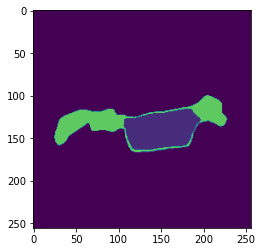

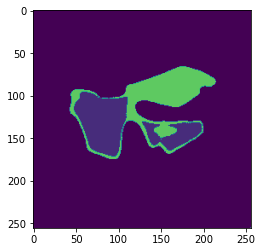

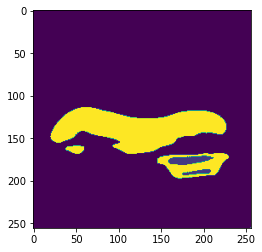

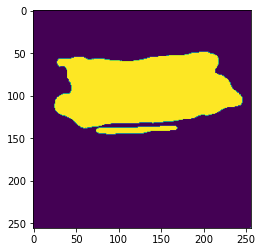

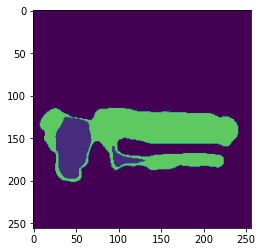

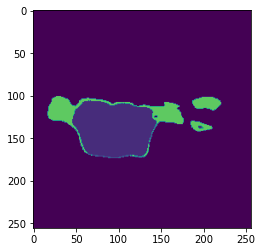

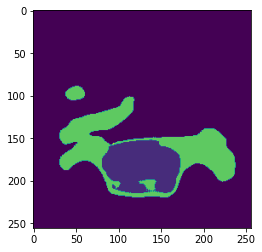

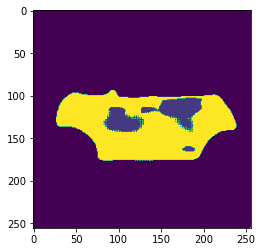

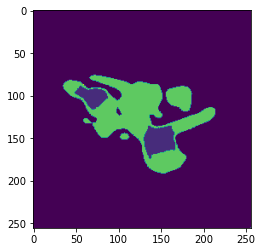

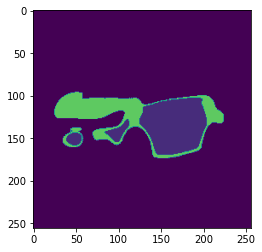

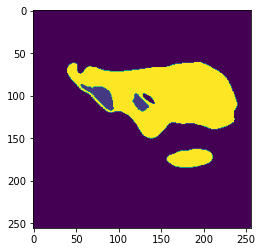

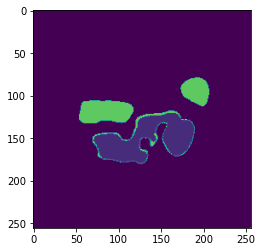

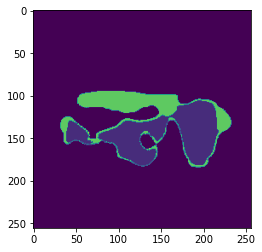

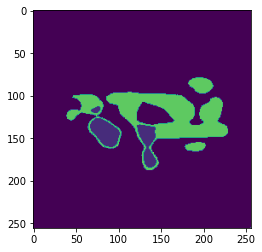

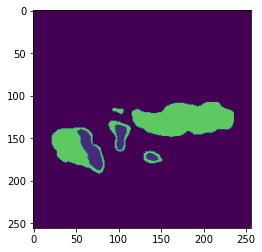

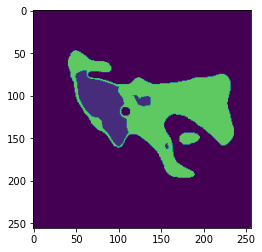

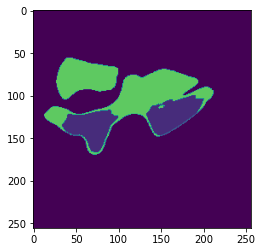

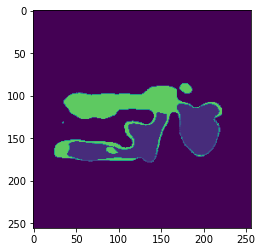

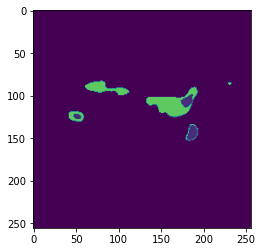

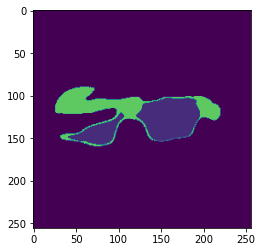

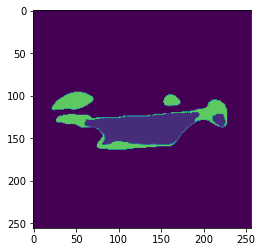

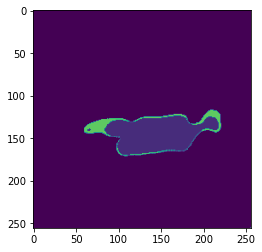

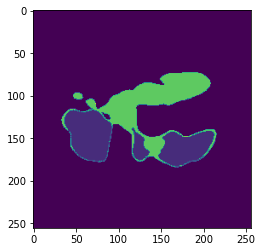

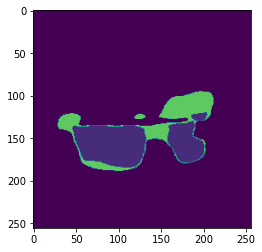

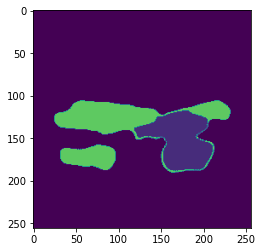

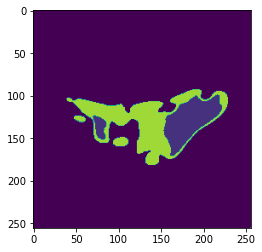

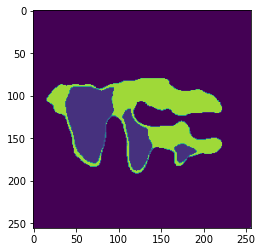

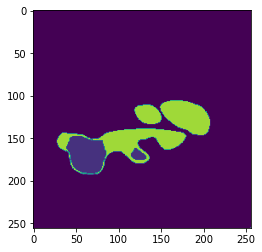

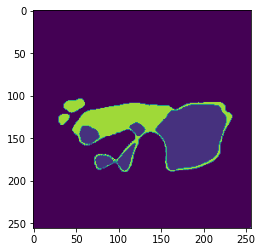

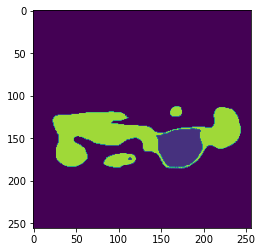

In [26]:

for i in range (30):
	plot(testdata,i)
